In [1]:
%matplotlib inline

In [2]:
#import logging
import os
import random

import numpy as np
import tensorflow as tf

import sys 
sys.path.append(os.path.abspath("/home/himani/learning_to_remember_rare_events"))

import data_utils
import model

import matplotlib.pylab as plt

In [3]:
FLAGS = tf.flags.FLAGS

tf.flags.DEFINE_integer('rep_dim', 128,
                        'dimension of keys to use in memory')
tf.flags.DEFINE_integer('episode_length', 30, 'length of episode')
tf.flags.DEFINE_integer('episode_width', 5,
                        'number of distinct labels in a single episode')
tf.flags.DEFINE_integer('memory_size', 8192, 'number of slots in memory. '
                        'Leave as None to default to episode length')
tf.flags.DEFINE_integer('batch_size', 16, 'batch size')
tf.flags.DEFINE_integer('num_episodes', 100000, 'number of training episodes')
tf.flags.DEFINE_integer('validation_frequency', 1,
                        'every so many training episodes, '
                        'assess validation accuracy')
tf.flags.DEFINE_integer('validation_length', 50,
                        'number of episodes to use to compute '
                        'validation accuracy')
tf.flags.DEFINE_integer('seed', 888, 'random seed for training sampling')
tf.flags.DEFINE_string('save_dir', '', 'directory to save model to')
tf.flags.DEFINE_bool('use_lsh', False,
                     'use locality-sensitive hashing '
                     '(NOTE: not fully tested)')

### Data Exploration

In [4]:
train_data, test_data=data_utils.get_data()

In [6]:
print('Number of train unique classes: %d'%len(train_data))
print('Number of test unique classes: %d'%len(test_data))

Number of train unique classes: 3856
Number of test unique classes: 659


In [7]:
np.random.seed(100)

In [11]:
i=np.random.choice(train_data.keys())
print(i)
j=np.random.choice(test_data.keys())
print(j)

3810
3963


In [12]:
print('Number of samples per train class: %d'%len(train_data[i]))
print('Number of samples per test class: %d'%len(test_data[j]))

Number of samples per train class: 20
Number of samples per test class: 20


(784,)
(28, 28)


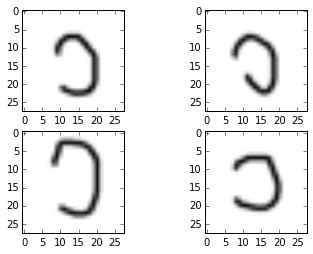

In [13]:
IMAGE_NEW_SIZE = data_utils.IMAGE_NEW_SIZE

for k in range(0,4):
    train_sample=train_data[i][np.random.randint(len(train_data[i]))]
    train_sample_img=np.reshape(train_sample,(IMAGE_NEW_SIZE,IMAGE_NEW_SIZE))
    plt.subplot(2, 2, k+1)
    plt.imshow(train_sample_img,cmap='gray')

print(train_sample.shape)
print(train_sample_img.shape)

In [3]:
def get_model(self):
    # vocab size is the number of distinct values that
    # could go into the memory key-value storage
    vocab_size = self.episode_width * self.batch_size
    return model.Model(
        self.input_dim, self.output_dim, self.rep_dim, self.memory_size,
        vocab_size, use_lsh=self.use_lsh)

def compute_correct(self, ys, y_preds):
    return np.mean(np.equal(y_preds, np.array(ys)))

def individual_compute_correct(self, y, y_pred):
    return y_pred == y

In [4]:
def sample_episode_batch(self, data,
                           episode_length, episode_width, batch_size):
    """Generates a random batch for training or validation.

    Structures each element of the batch as an 'episode'.
    Each episode contains episode_length examples and
    episode_width distinct labels.

    Args:
      data: A dictionary mapping label to list of examples.
      episode_length: Number of examples in each episode.
      episode_width: Distinct number of labels in each episode.
      batch_size: Batch size (number of episodes).

    Returns:
      A tuple (x, y) where x is a list of batches of examples
      with size episode_length and y is a list of batches of labels.
    """
    episodes_x = [[] for _ in xrange(episode_length)]
    episodes_y = [[] for _ in xrange(episode_length)]
    assert len(data) >= episode_width
    keys = data.keys()
    for b in xrange(batch_size):
        episode_labels = random.sample(keys, episode_width)
        remainder = episode_length % episode_width
        remainders = [0] * (episode_width - remainder) + [1] * remainder
        episode_x = [random.sample(data[lab],
                    r + (episode_length - remainder) / episode_width)
                    for lab, r in zip(episode_labels, remainders)]
        episode = sum([[(x, i, ii) for ii, x in enumerate(xx)]
                for i, xx in enumerate(episode_x)], [])
        random.shuffle(episode)
        # Arrange episode so that each distinct label is seen before moving to
        # 2nd showing
        episode.sort(key=lambda elem: elem[2])
        assert len(episode) == episode_length
        for i in xrange(episode_length):
            episodes_x[i].append(episode[i][0])
            episodes_y[i].append(episode[i][1] + b * episode_width)

    return ([np.array(xx).astype('float32') for xx in episodes_x],
            [np.array(yy).astype('int32') for yy in episodes_y])

In [5]:
def run(self):
    """Performs training.

    Trains a model using episodic training.
    Every so often, runs some evaluations on validation data.
    """
    train_data, valid_data = self.train_data, self.valid_data
    input_dim, output_dim = self.input_dim, self.output_dim
    rep_dim, episode_length = self.rep_dim, self.episode_length
    episode_width, memory_size = self.episode_width, self.memory_size
    batch_size = self.batch_size

    train_size = len(train_data)
    valid_size = len(valid_data)
    print('train_size (number of labels) %d'%(train_size))
    print('valid_size (number of labels) %d'%(valid_size))
    print('input_dim %d'%(input_dim))
    print('output_dim %d'%(output_dim))
    print('rep_dim %d'%(rep_dim))
    print('episode_length %d'%(episode_length))
    print('episode_width %d'%(episode_width))
    print('memory_size %d'%(memory_size))
    print('batch_size %d'%(batch_size))

    assert all(len(v) >= float(episode_length) / episode_width
            for v in train_data.itervalues())
    assert all(len(v) >= float(episode_length) / episode_width
            for v in valid_data.itervalues())

    output_dim = episode_width
    self.model = self.get_model()
    self.model.setup()

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver(max_to_keep=10)
    ckpt = None
    if FLAGS.save_dir:
        ckpt = tf.train.get_checkpoint_state(FLAGS.save_dir)
    if ckpt and ckpt.model_checkpoint_path:
        print('restoring from %s'%(ckpt.model_checkpoint_path))
        saver.restore(sess, ckpt.model_checkpoint_path)

    print('starting now')
    losses = []
    random.seed(FLAGS.seed)
    np.random.seed(FLAGS.seed)
    for i in xrange(FLAGS.num_episodes):
        x, y = self.sample_episode_batch(
        train_data, episode_length, episode_width, batch_size)
        outputs = self.model.episode_step(sess, x, y, clear_memory=True)
        loss = outputs
        losses.append(loss)
            
        if i % FLAGS.validation_frequency == 0:
            print('episode batch %d, avg train loss %f'%(i, np.mean(losses)))
            losses = []

            # validation
            correct = []
            correct_by_shot = dict((k, []) for k in xrange(self.episode_width + 1))
            for _ in xrange(FLAGS.validation_length):
                x, y = self.sample_episode_batch(
                    valid_data, episode_length, episode_width, 1)
                outputs = self.model.episode_predict(
                    sess, x, y, clear_memory=True)
                y_preds = outputs
                correct.append(self.compute_correct(np.array(y), y_preds))

            # compute per-shot accuracies
            seen_counts = [[0] * episode_width for _ in xrange(batch_size)]
            # loop over episode steps
            for yy, yy_preds in zip(y, y_preds):
            # loop over batch examples
                for k, (yyy, yyy_preds) in enumerate(zip(yy, yy_preds)):
                    yyy, yyy_preds = int(yyy), int(yyy_preds)
                    count = seen_counts[k][yyy % self.episode_width]
                    if count in correct_by_shot:
                        correct_by_shot[count].append(
                            self.individual_compute_correct(yyy, yyy_preds))
                    seen_counts[k][yyy % self.episode_width] = count + 1

        print('validation overall accuracy %f'%(np.mean(correct)))
        print_list=sum([[k, np.mean(correct_by_shot[k])]
               for k in xrange(self.episode_width + 1)], [])
        print_str=''
        xx=0
        while xx < (len(print_list)):
            print_str=print_str+('%d-shot: %.3f, '%(print_list[xx],print_list[xx+1]))
            xx+=2
        print(print_str)
                
        #print('%d-shot: %.3f, '.format(*self.episode_width + 1, 
        #      sum([[k, np.mean(correct_by_shot[k])]
        #       for k in xrange(self.episode_width + 1)], [])))

        if saver and FLAGS.save_dir:
            saved_file = saver.save(sess,
                        os.path.join(FLAGS.save_dir, 'model.ckpt'),
                        global_step=self.model.global_step)
            print('saved model to %s'%(saved_file))

In [6]:
class Trainer(object):
    """Class that takes care of training, validating, and checkpointing model."""
    def __init__(self, train_data, valid_data, input_dim, output_dim=None):
        self.train_data = train_data
        self.valid_data = valid_data
        self.input_dim = input_dim

        self.rep_dim = FLAGS.rep_dim
        self.episode_length = FLAGS.episode_length
        self.episode_width = FLAGS.episode_width
        self.batch_size = FLAGS.batch_size
        self.memory_size = (self.episode_length * self.batch_size
                        if FLAGS.memory_size is None else FLAGS.memory_size)
        self.use_lsh = FLAGS.use_lsh

        self.output_dim = (output_dim if output_dim is not None
                       else self.episode_width)
        print('Class object created')

Trainer.get_model=get_model
Trainer.compute_correct=compute_correct
Trainer.individual_compute_correct=individual_compute_correct
Trainer.sample_episode_batch=sample_episode_batch
Trainer.run=run

In [7]:
#logging.basicConfig(level=logging.DEBUG)
train_data, valid_data = data_utils.get_data()
trainer = Trainer(train_data, valid_data, data_utils.IMAGE_NEW_SIZE ** 2)

Class object created


In [8]:
trainer.run()

train_size (number of labels) 3856
valid_size (number of labels) 659
input_dim 784
output_dim 5
rep_dim 128
episode_length 30
episode_width 5
memory_size 8192
batch_size 16
starting now
episode batch 0, avg train loss 0.274124
validation overall accuracy 0.496667
6
[0, 0.0, 1, 0.59999999999999998, 2, 0.40000000000000002, 3, 0.80000000000000004, 4, 1.0, 5, 0.80000000000000004]
0-shot: 0.000, 1-shot: 0.600, 2-shot: 0.400, 3-shot: 0.800, 4-shot: 1.000, 5-shot: 0.800, 
episode batch 1, avg train loss 0.225530
validation overall accuracy 0.516000
6
[0, 0.0, 1, 0.80000000000000004, 2, 0.80000000000000004, 3, 1.0, 4, 1.0, 5, 0.80000000000000004]
0-shot: 0.000, 1-shot: 0.800, 2-shot: 0.800, 3-shot: 1.000, 4-shot: 1.000, 5-shot: 0.800, 
episode batch 2, avg train loss 0.211496
validation overall accuracy 0.490667
6
[0, 0.0, 1, 0.40000000000000002, 2, 0.59999999999999998, 3, 0.80000000000000004, 4, 0.59999999999999998, 5, 0.80000000000000004]
0-shot: 0.000, 1-shot: 0.400, 2-shot: 0.600, 3-shot: 

KeyboardInterrupt: 